# I developed a Personal Expense Pattern Analyzer using Machine Learning. The system classifies expense categories, predicts monthly spending using regression, and detects abnormal transactions using Isolation Forest. I also performed feature engineering and model evaluation to ensure performance and reliability.

# Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error



In [22]:
df = pd.read_csv("expense_data.csv")
df.head(3)

,Date,Category,Amount,Payment_Mode,Description
0,2024-02-09,Bills,3451,Debit Card,Expense
1,2024-04-16,Food,653,UPI,Expense
2,2024-05-15,Transport,281,Credit Card,Expense


# Data Preprocessing & Feature Engineering

In [23]:
df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)


# Encode Categorical Variables

In [24]:
le_category = LabelEncoder()
le_payment = LabelEncoder()

df['Category_Encoded'] = le_category.fit_transform(df['Category'])
df['Payment_Encoded'] = le_payment.fit_transform(df['Payment_Mode'])



# PART 1 : Expense Category Classification

# Prepare Features

In [25]:
features = [
    'Amount', 'Month', 'Day', 'Weekday',
    'Is_Weekend', 'Payment_Encoded'
]

X = df[features]
y = df['Category_Encoded']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)





# Train Random Forest Classifier

In [26]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\n🔹 Classification Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n")
print(classification_report(y_test, y_pred))



🔹 Classification Accuracy: 0.55

🔹 Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.62      0.62        37
           1       0.32      0.41      0.36        29
           2       0.61      0.56      0.58        41
           3       0.36      0.46      0.41        28
           4       0.54      0.35      0.43        37
           5       0.93      0.93      0.93        28

    accuracy                           0.55       200
   macro avg       0.56      0.56      0.55       200
weighted avg       0.57      0.55      0.55       200



In [27]:
# SAVE CLASSIFICATION MODEL & SCALER 

pickle.dump(clf, open("expense_classifier_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))

print("✅ Classification model & scaler saved")


✅ Classification model & scaler saved


# PART 2: Monthly Expense Prediction (Regression)

# Create Monthly Aggregation

In [28]:
monthly_data = df.groupby('Month')['Amount'].sum().reset_index()

# Train Regression Model

In [29]:
X_reg = monthly_data[['Month']]
y_reg = monthly_data['Amount']

reg_model = RandomForestRegressor(n_estimators=200, random_state=42)
reg_model.fit(X_reg, y_reg)

predicted = reg_model.predict(X_reg)

print("Mean Absolute Error:", mean_absolute_error(y_reg, predicted))

Mean Absolute Error: 10233.275833333324


In [30]:
# SAVE REGRESSION MODEL
pickle.dump(reg_model, open("monthly_expense_regressor.pkl", "wb"))
print("✅ Regression model saved")


✅ Regression model saved


# Plot Monthly Trend

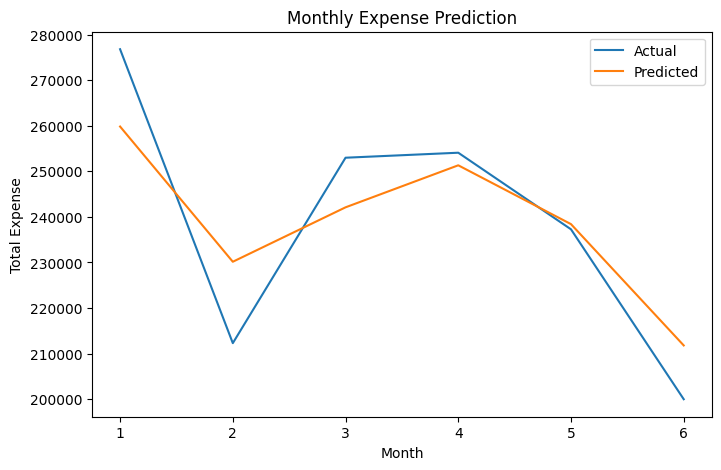

In [31]:
plt.figure(figsize=(8,5))
plt.plot(monthly_data['Month'], y_reg, label="Actual")
plt.plot(monthly_data['Month'], predicted, label="Predicted")
plt.title("Monthly Expense Prediction")
plt.xlabel("Month")
plt.ylabel("Total Expense")
plt.legend()
plt.show()

# PART 3: Anomaly Detection

# Detect Unusual Transactions

In [32]:
iso = IsolationForest(contamination=0.03, random_state=42)
df['Anomaly'] = iso.fit_predict(df[['Amount']])

# -1 means anomaly

In [33]:
# SAVE ANOMALY MODEL 
pickle.dump(iso, open("anomaly_detector.pkl", "wb"))
print("✅ Anomaly detection model saved")



✅ Anomaly detection model saved


# Visualize Anomalies

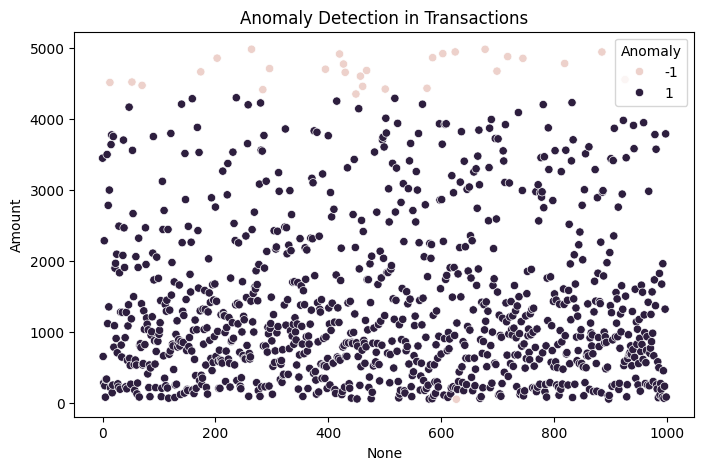

In [34]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df.index, y=df['Amount'], hue=df['Anomaly'])
plt.title("Anomaly Detection in Transactions")
plt.show()

# Data Visualization

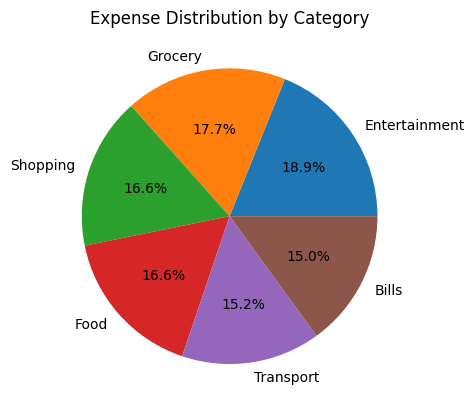

In [35]:
# Expense Category Distribution
df['Category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Expense Distribution by Category")
plt.ylabel("")
plt.show()


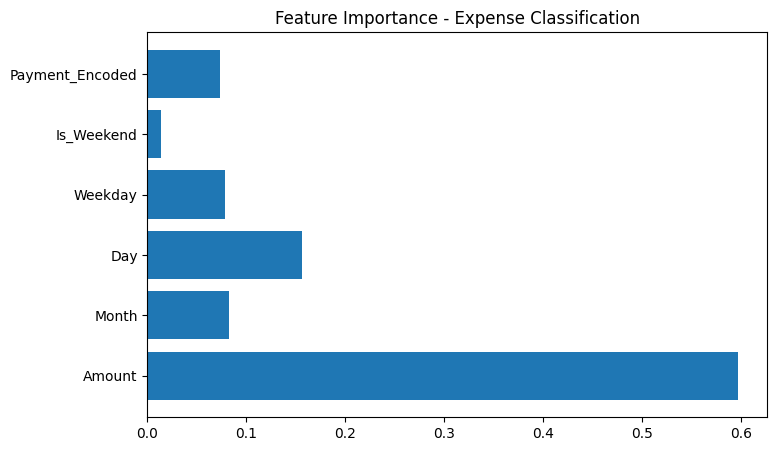

In [36]:
# Feature Importance
importances = clf.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.title("Feature Importance - Expense Classification")
plt.show()


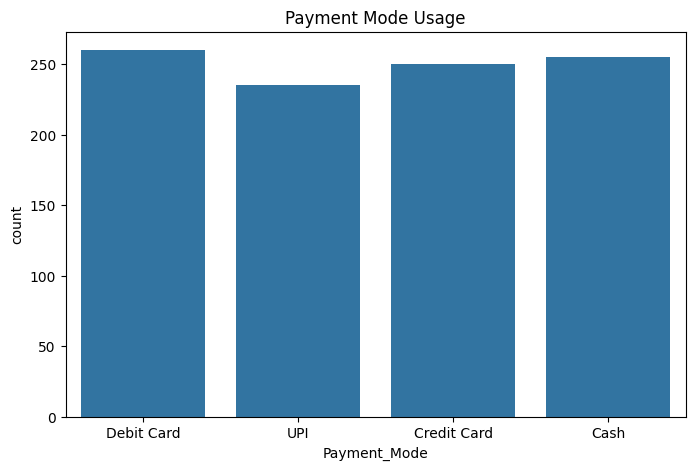

In [37]:
# Payment Mode Usage
plt.figure(figsize=(8,5))
sns.countplot(x='Payment_Mode', data=df)
plt.title("Payment Mode Usage")
plt.show()